# Analysis on Casino Blackjack
This notebook is created in purpose of running the analysis on whether strategy of counting cards is effective when trying to play a blackjack. Here, I am using a basic blackjack strategy outlined in https://www.blackjackapprenticeship.com/wp-content/uploads/2018/08/BJA_Basic_Strategy.jpg, however in this case, I am assuming no splitting are allowed for simplicity of the analysis. Additionally, another strategy that can be used is where when the dealer's card is higher than player's card - 10, then player should hit, unless the player has cards above or equal to 17. Additionally. always double in 11 and double on or 9 when the dealer's card is lower than 7.

Packages imported have `participant` and `blackjack`, which are classes that is used to simulate a game of blackjack. Additionally, import `settings` which include global variables that will be used. Lastly, imports 3 basic python packages, `tqdm`, `matplotlib.pyplot` and `numpy`

In [2]:
from module.classes.participant import participant
from module.classes.blackjack import blackjack
from module.settings import settings
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

Below variables that is needed to start the analysis. mainly, the `num_cards` and `count`, which are the count of each cards in the deck as well as the current running count.

In [11]:
START_NUM_CARDS = [settings.N_DECKS * settings.N_CARD_EACH_DECK] * len(settings.CARDS)
DECK_LIMIT = 6
CARD_LIMIT = DECK_LIMIT * len(settings.CARDS) * settings.N_CARD_EACH_DECK

num_cards, count = START_NUM_CARDS.copy(), 0
dealer_runV      = []
dealer_runW      = []

Below are some variables that may be changed to affect the outcome of the analysis. In this case we only used 4 players in the game, which respective strategies.

In [12]:
n_sim          = 2500
n_players      = 4
strategies     = ['strategy_A', 'strategy_A_alt', 'strategy_B', 'strategy_B_alt']

assert n_players == len(strategies), 'Number of players must equal to the number of strategies'

In [13]:
# Create the labels for plotting later on
players, labels  = [], ['dealer']
for i in range(n_players): 
    players.append(participant())
    labels.append('player %s'%(i + 1))

Run the Simulation

In [14]:
for sim in tqdm(range(n_sim)):
    # Check if the number of cards depleted
    if sum(num_cards) < CARD_LIMIT: num_cards, count = START_NUM_CARDS.copy(), 0
    
    blackjack_game = blackjack(num_cards, count)
    blackjack_game.add_player(*players)
    for player, strategy in zip(blackjack_game.players, strategies): 
        player.set_bet(settings.MIN_BET)
        player.set_strategy(strategy, count, num_cards)
    num_cards, count = blackjack_game.play()
    
    # Did all lose?
    all_lose = 1
    for player in blackjack_game.players:
        if player.runW[-1] > 0: all_lose = -1
    
    dealer_runV.append(blackjack_game.dealer.value)
    dealer_runW.append(all_lose)

100%|██████████| 500/500 [00:04<00:00, 100.90it/s]


Calculate the probability / proportion of getting standoffs (when the dealer got 22), or when the player/dealer get bust, win, high-cards or blackjacks. These are then used to create the plot shown in the visualisation section at the bottom.

In [ ]:
p_bust, p_win, p_high, p_bljk = {}, {}, {}, {}
p_stdoff = sum([val == 22 for val in dealer_runV])/n_sim ## Probability of Standoffs (Dealer got 22)

allRunV  = [dealer_runV]
allRunW  = [dealer_runW]
bar_color = [settings.PLOT_COLOR_DEALER]
for player in blackjack_game.players:
    allRunV.append(player.runV)
    allRunW.append(player.runW)
    bar_color.append(settings.PLOT_COLOR_PLAYER)

## Probability of Bust
for p, label in zip(allRunV, labels): p_bust[label] = sum([val == 0 for val in p])/n_sim

## Probability of Win
for p, label in zip(allRunW, labels): p_win[label] = sum([val > 0 for val in p])/sum([val != 0 for val in p])

## Probability of High-Cards (18, 19 and 20)
for p, label in zip(allRunV, labels): p_high[label] = sum([val > 17 for val in p])/n_sim

## Probability of Blackjacks
for p, label in zip(allRunV, labels): p_bljk[label] = sum([val == 21 for val in p])/sum([val != 0 for val in p])

#### Visualisation Section

Proportion of stand-offs 0.0741


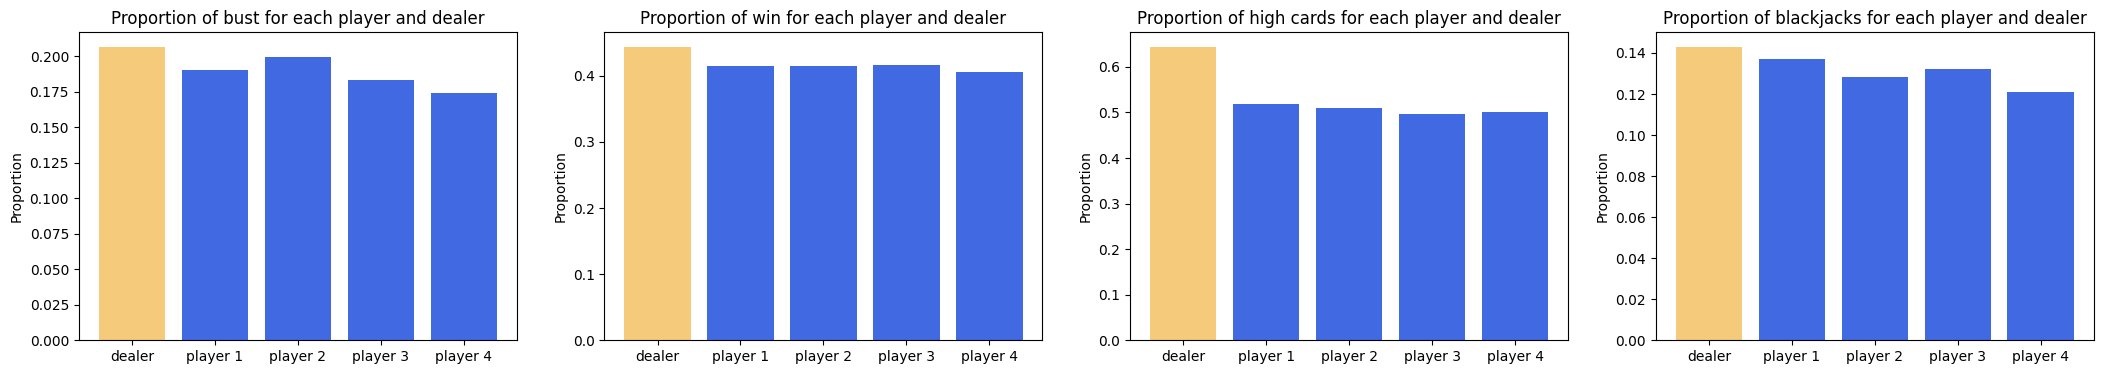

In [8]:
fig, ax = plt.subplots(1, 4, figsize = (26, 4))
ax[0].bar(p_bust.keys(), p_bust.values(), color = bar_color)
ax[0].set_title('Proportion of bust for each player and dealer')
ax[0].set_ylabel('Proportion')

ax[1].bar(p_win.keys(), p_win.values(), color = bar_color)
ax[1].set_title('Proportion of win for each player and dealer')
ax[1].set_ylabel('Proportion')

ax[2].bar(p_high.keys(), p_high.values(), color = bar_color)
ax[2].set_title('Proportion of high cards for each player and dealer')
ax[2].set_ylabel('Proportion')

ax[3].bar(p_bljk.keys(), p_bljk.values(), color = bar_color)
ax[3].set_title('Proportion of blackjacks for each player and dealer')
ax[3].set_ylabel('Proportion')

print('Proportion of stand-offs %s' %p_stdoff)
plt.show()

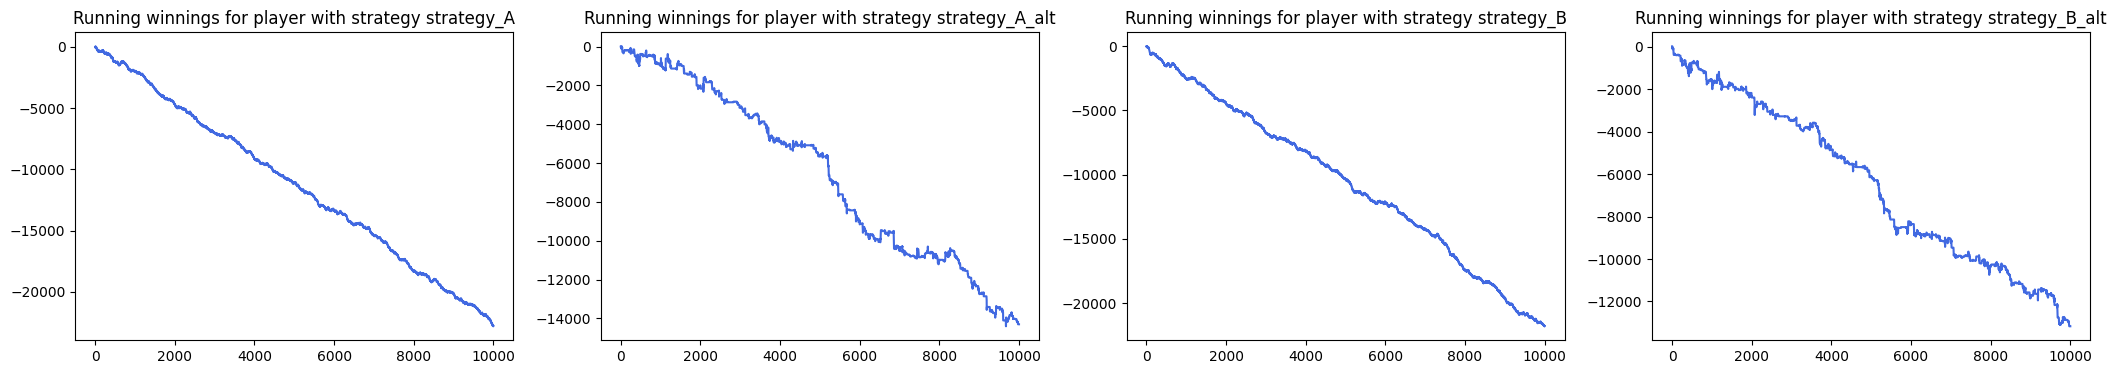

In [9]:
if n_players > 4:
    rows, cols = int(n_players/4) + 1, n_players
    figsize_   = (7 * cols - 2, rows * 5 - 1)
    
    fig, ax = plt.subplots(rows, cols, figsize = figsize_)
    for i, player in enumerate(blackjack_game.players):
        r, c = int(i/4), i % 4
        ax[r][c].plot(np.cumsum(player.runW), color = settings.PLOT_COLOR_PLAYER)
        ax[r][c].set_title('Running winnings for player with strategy %s' %strategies[i])
else:
    fig, ax = plt.subplots(1, n_players, figsize = (26, 4))
    for i, player in enumerate(blackjack_game.players):
        ax[i].plot(np.cumsum(player.runW), color = settings.PLOT_COLOR_PLAYER)
        ax[i].set_title('Running winnings for player with strategy %s' %strategies[i])

It is interesting to see that the final running winnings of all strategies that used counting result in a much better result compared to not using any counting at all. Ultimately, we can compare strategy of not using vs using counting.

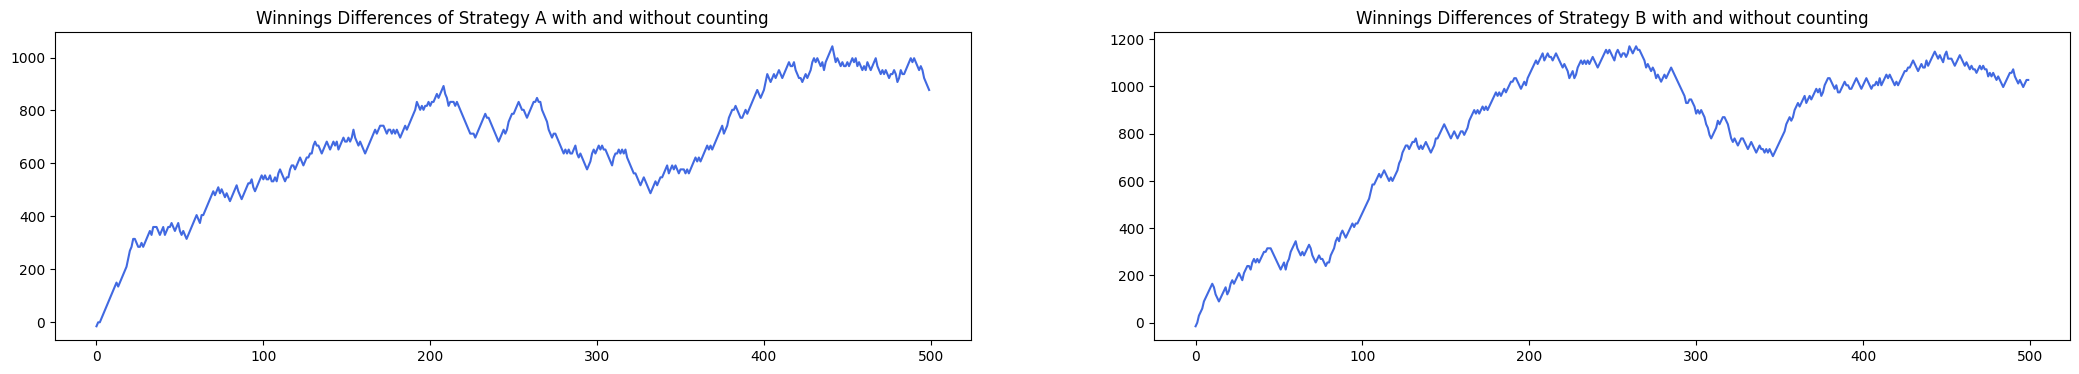

In [43]:
# Strategy A vs Strategy A with Counting
strategyA_diffs = np.cumsum(blackjack_game.players[1].runW) - np.cumsum(blackjack_game.players[0].runW)

# Strategy B vs Strategy B with Counting
strategyB_diffs = np.cumsum(blackjack_game.players[3].runW) - np.cumsum(blackjack_game.players[2].runW)

fig, ax = plt.subplots(1, 2, figsize = (26, 4))
ax[0].plot(strategyA_diffs, color = settings.PLOT_COLOR_PLAYER)
ax[0].set_title('Winnings Differences of Strategy A with and without counting')
ax[1].plot(strategyB_diffs, color = settings.PLOT_COLOR_PLAYER)
ax[1].set_title('Winnings Differences of Strategy B with and without counting')
plt.show()